# k-means with text data

In [1]:
import pandas as pd                                                 
import matplotlib.pyplot as plt                                # plotting
import numpy as np                                             # dense matrices
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.preprocessing import normalize                    # normalizing vectors
from sklearn.metrics import pairwise_distances                 # pairwise distances
import sys      
import os
%matplotlib inline

In [2]:
wiki = pd.read_csv('data/people_wiki.csv')

In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']

    return csr_matrix( (data, indices, indptr), shape)

tf_idf = load_sparse_csr('data/people_wiki_tf_idf.npz')


In [6]:
tf_idf.shape

(59071, 547979)

In [5]:
import json
with open('data/people_wiki_map_index_to_word.json', 'r') as f:
    map_index_to_word  = json.load(f)


## Normalize all vectors

In [7]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

In [8]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

In [11]:
# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print(dist)

[[1.41000789 1.36894636]
 [1.40935215 1.41023886]
 [1.39855967 1.40890299]
 ...
 [1.41108296 1.39123646]
 [1.41022804 1.31468652]
 [1.39899784 1.41072448]]


In [15]:
centrois = tf_idf[0:3,:]
dist_cent = pairwise_distances(tf_idf, centrois, metric='euclidean')
dist = dist_cent[430][1]

In [16]:
'''Test cell'''
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


In [18]:
closest_cluster = [np.argmin(dist_cent[i]) for i in range(len(dist_cent))]

In [21]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in dist_cent]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


In [22]:
cluster_assignment=closest_cluster

In [23]:
if len(cluster_assignment)==59071 and \
   np.array_equal(np.bincount(cluster_assignment), np.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


In [28]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = [np.argmin(distances_from_centroids[i]) for i in range(len(distances_from_centroids))]
    
    return np.array(cluster_assignment)

In [29]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


In [47]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

In [49]:
cluster_assignment = assign_clusters(data, centroids)
print (cluster_assignment)   # prints [0 1 0]

[0 1 0]


In [32]:
print (data[cluster_assignment==1])

[[0. 0. 0.]]


In [33]:
print (data[cluster_assignment==0])

[[1. 2. 0.]
 [2. 2. 0.]]


In [34]:
print(data[cluster_assignment==0].mean(axis=0))

[1.5 2.  0. ]


In [35]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points .mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)

    
    return new_centroids

In [36]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


In [38]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [50]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

In [39]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [40]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1
    19157 elements changed their cluster assignment.
2
     7739 elements changed their cluster assignment.
3
     5119 elements changed their cluster assignment.
4
     3370 elements changed their cluster assignment.
5
     2811 elements changed their cluster assignment.
6
     3233 elements changed their cluster assignment.
7
     3815 elements changed their cluster assignment.
8
     3172 elements changed their cluster assignment.
9
     1149 elements changed their cluster assignment.
10
      498 elements changed their cluster assignment.
11
      265 elements changed their cluster assignment.
12
      149 elements changed their cluster assignment.
13
      100 elements changed their cluster assignment.
14
       76 elements changed their cluster assignment.
15
       67 elements changed their cluster assignment.
16
       51 elements changed their cluster assignment.
17
       47 elements changed their cluster assignment.
18
       40 elements changed their cluster assignment.

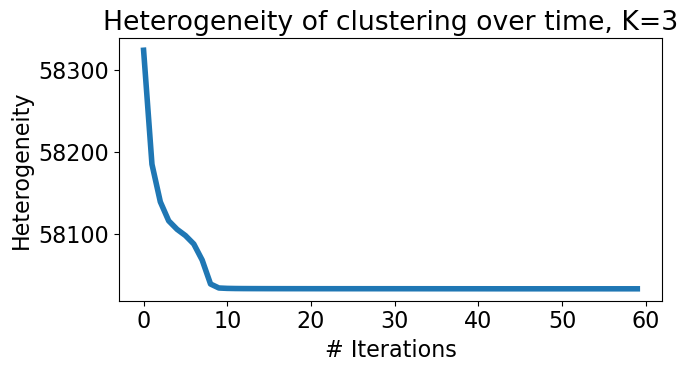

In [59]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [65]:
print(np.argmax(np.bincount(cluster_assignment)))
len(cluster_assignment[cluster_assignment==np.argmax(np.bincount(cluster_assignment))])


2


29049

## Beware of local minima

In [66]:
k = 10
heterogeneity = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    cluster_largest = np.argmax(np.bincount(cluster_assignment))
    data_points = len(cluster_assignment[cluster_assignment==cluster_largest])
    print("largest cluster: ", (cluster_largest, data_points))
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

largest cluster:  (0, 18047)
seed=000000, heterogeneity=57457.52442
largest cluster:  (4, 15779)
seed=020000, heterogeneity=57533.20100
largest cluster:  (9, 18132)
seed=040000, heterogeneity=57512.69257
largest cluster:  (9, 17900)
seed=060000, heterogeneity=57466.97925
largest cluster:  (0, 17582)
seed=080000, heterogeneity=57494.92990
largest cluster:  (4, 16969)
seed=100000, heterogeneity=57484.42210
largest cluster:  (6, 16481)
seed=120000, heterogeneity=57554.62410
310.24645376205444


In [67]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

In [70]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    cluster_largest = np.argmax(np.bincount(cluster_assignment))
    data_points = len(cluster_assignment[cluster_assignment==cluster_largest])
    print("largest cluster: ", (cluster_largest, data_points))
    sys.stdout.flush()

end = time.time()
print("It took ",(end-start)," seconds")

seed=000000, heterogeneity=57468.63808
largest cluster:  (0, 19618)
seed=020000, heterogeneity=57486.94263
largest cluster:  (3, 20581)
seed=040000, heterogeneity=57454.35926
largest cluster:  (0, 17602)
seed=060000, heterogeneity=57530.43659
largest cluster:  (4, 16942)
seed=080000, heterogeneity=57454.51852
largest cluster:  (5, 18352)
seed=100000, heterogeneity=57471.56674
largest cluster:  (3, 17792)
seed=120000, heterogeneity=57523.28839
largest cluster:  (3, 16549)
It took  430.4037230014801  seconds


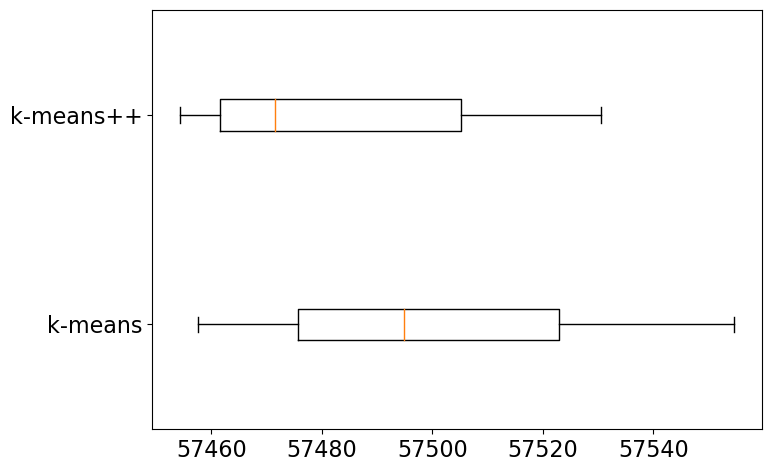

In [86]:
plt.figure(figsize=(8,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [87]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in range(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        initial_centroids = smart_initialize(data, k, seed)
        
        # Run k-means
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter=400,record_heterogeneity=None, verbose=False)
        
        # To save time, compute heterogeneity only once in the end
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

In [88]:
#def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
#    plt.figure(figsize=(7,4))
#    plt.plot(k_values, heterogeneity_values, linewidth=4)
#    plt.xlabel('K')
#    plt.ylabel('Heterogeneity')
#    plt.title('K vs. Heterogeneity')
#    plt.rcParams.update({'font.size': 16})
#    plt.tight_layout()

#start = time.time()
#centroids = {}
#cluster_assignment = {}
#heterogeneity_values = []
#k_list = [2, 10, 25, 50, 100]
#seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]

#for k in k_list:
#    heterogeneity = []
#    centroids[k], cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
#                                                               num_runs=len(seed_list),
#                                                               seed_list=seed_list,
#                                                               verbose=True)
#    score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
#    heterogeneity_values.append(score)

#plot_k_vs_heterogeneity(k_list, heterogeneity_values)

#end = time.time()
#print(end-start)

2
10
25
50
100


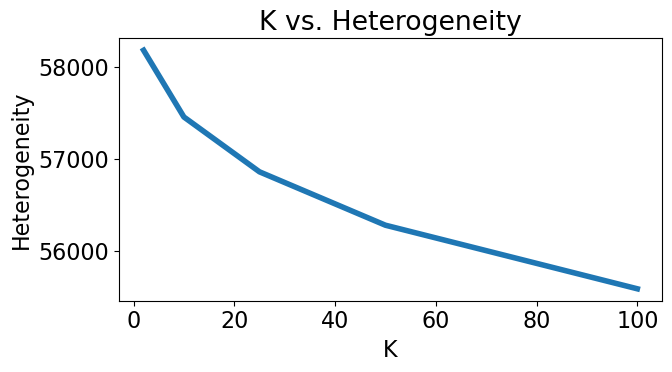

In [91]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

filename = 'data/kmeans-arrays.npz'

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print (k)
        sys.stdout.flush()
        centroids[k] = arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')

In [102]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        print(idx)
        for i in range(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(list(map_index_to_word.keys())[idx[i]], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, [centroids[c]], metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(8):
                text = ' '.join(wiki['text'][nearest_neighbors[i]].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki['name'][nearest_neighbors[i]],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

In [103]:
visualize_document_clusters(wiki, tf_idf, centroids[2], cluster_assignment[2], 2, map_index_to_word)

Cluster 0    
[547896 547903 547870 ...  67039  67041 227635]
serieslong:0.025
bostonas:0.017
33story:0.012
gan:0.011
efovi:0.011


* Anita Kunz                                         0.97401
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working

* Janet Jackson                                      0.97472
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Madonna (entertainer)                              0.97475
  madonna louise ciccone tkoni born august 16 1958 is an american singer songwriter actress 
  and businesswoman she achieved popularity by pushing the boundaries of lyrical

* %C3%81ine Hyland                                   0.97536
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born i

In [105]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k, map_index_to_word)

Cluster 0    
[547818 547693 547966 ... 260522 469269 218684]
allmvfc:0.020
scientistagreed:0.014
gan:0.011
psihomodo:0.010
2001pasithee:0.010


* Wilson McLean                                      0.97479
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Anton Hecht                                        0.97748
  anton hecht is an english artist born in london in 2007 he asked musicians from around the
   durham area to contribute to a soundtrack for

* David Salle                                        0.97800
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned

* Vipin Sharma                                       0.97805
  vipin sharma is an indian actor born in new delhi he is a graduate of national school of d
  rama new delhi india and the canadian

* Paul Swade

In [106]:
np.bincount(cluster_assignment[10])

array([17602,  3415,  3535,  1736,  6445,  2552,  7106,  7155,   599,
        8926])

In [107]:
visualize_document_clusters(wiki, tf_idf, centroids[25], cluster_assignment[25], 25,
                            map_index_to_word, display_content=False) # turn off text for brevity

Cluster 0    
[547685 547550 547479 ... 346110 346111      0]
blitzattack:0.077
addie:0.048
recordingstheir:0.046
buntingfrom:0.038
hettingers:0.038

Cluster 1    
[547784 547824 547734 ... 342004 342005      0]
preposition:0.054
2210:0.033
hundreaarsvisningen:0.032
efovi:0.031
allenshortly:0.029

Cluster 2    
[546289 545222 546386 ... 358746 358747      0]
ibnez:0.216
jeffnominated:0.134
usyd:0.065
sibinki:0.052
19771992according:0.047

Cluster 3    
[547729 547647 547768 ... 342592 342593      0]
zahida:0.065
pricepottenger:0.042
newsweekkhan:0.031
trag:0.027
slowburn:0.023

Cluster 4    
[547775 547866 547621 ... 337038 337039      0]
incertidumbre:0.025
2012frostad:0.023
hareher:0.022
dumbblonde:0.022
disbandedkirwan:0.020

Cluster 5    
[547563 547092 546715 ... 354042 354043      0]
lopilato:0.160
madeamhali:0.056
1200in:0.044
zahida:0.043
pricepottenger:0.042

Cluster 6    
[547954 547824 547736 ... 343143 343144      0]
efovi:0.044
2210:0.037
rezas:0.035
wone:0.034
chandanapal

In [109]:
k=100
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k,
                            map_index_to_word, display_content=False)
# turn off text for brevity -- turn it on if you are curious ;)

Cluster 0    
[545205 546212 547722 ... 358649 358650      0]
isolates:0.137
zincavage:0.082
asiabased:0.056
pantherslabowitch:0.053
machairitsas:0.050

Cluster 1    
[545806 543673 543929 ... 358590 358591      0]
keimyung:0.170
razed:0.085
pozsgay:0.083
lectrices:0.072
1065ray:0.058

Cluster 2    
[546701 547953 543788 ... 359605 359606      0]
proa:0.247
examinationspaulker:0.069
10093:0.056
terribles:0.031
berr:0.029

Cluster 3    
[544167 545867 543734 ... 359310 359311      0]
queer:0.181
yearhansen:0.121
rostersleeth:0.042
awardspreviously:0.036
psihomodo:0.034

Cluster 4    
[545087 544614 542288 ... 361692 361693      0]
huld:0.309
1999derek:0.220
stagelavin:0.066
kartvelology:0.041
affiliatechoi:0.031

Cluster 5    
[547303 547732 546030 ... 358598 358599      0]
franquin:0.192
turhapuro:0.127
wayak:0.054
bruschi:0.046
ebu:0.042

Cluster 6    
[547146 547550 547509 ... 356303 356304      0]
hettingers:0.059
addie:0.053
eba:0.051
lohiau:0.049
damepazan:0.044

Cluster 7    
[54

In [110]:
np.bincount(cluster_assignment[100])

array([ 241,  346,  207,  207,   95,  286,  683,  394,  947,  446,  875,
         73,  374,  724,  299,  124,  679,  324, 1066,  622,  402,  428,
        141,  545,  549,  157,   34,  408,  397,   41, 1419,  722, 2025,
        301,  174,  297,  846, 1010,  348,   66,  690,  638, 1286,  488,
        931, 1480,  259,  338,  224,  504,  225,  165,  310,  110,  421,
         89,  190, 1379,   63,  433,  467,  194,  121,  569,  979,  535,
         43, 1291, 1274,  574,  670,  165,  155,  555, 1964,  175,  149,
        587,  133,  260, 5563,  257, 1146,  695,  402, 1497,  185,  477,
       1024,  256,  650, 1024,  500, 1393,  756, 1109, 1032,  182,  180,
        338])

In [113]:
len(np.bincount(cluster_assignment[100])[np.bincount(cluster_assignment[100])<236])

29